In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import datetime as dt
from datetime import timedelta

from sklearn.preprocessing import OrdinalEncoder


# Librerias para visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
# Fuentes y estilos
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

font = {'family':'serif',
       'color':'darkred',
       'weight':'normal',
       'size':16,
       }


In [3]:
os.chdir('D:/DS/Kaggle')

In [4]:
# Load data
pageviews = pd.read_csv('./pageviews.csv')
# content_category = pd.read_csv('./CONTENT_CATEGORY.csv')
# content_category_bottom = pd.read_csv('./CONTENT_CATEGORY_BOTTOM.csv')
# content_category_top = pd.read_csv('./CONTENT_CATEGORY_TOP.csv')
# device_data = pd.read_csv('./device_data.csv')
page = pd.read_csv('./PAGE.csv')
# site_id = pd.read_csv('./SITE_ID.csv')
conversiones = pd.read_csv('./conversiones.csv', dtype={'mes' : 'object', 'anio' : 'object', 'USER_ID' : 'object'})

###  Procesamiento archivo conversiones

Elimino el '.0' de los datos de conversiones

In [5]:
conversiones['mes'] = pd.to_numeric(conversiones['mes'].str.replace('\.0', ''))
conversiones['anio'] = pd.to_numeric(conversiones['anio'].str.replace('\.0', ''))
conversiones['USER_ID'] = pd.to_numeric(conversiones['USER_ID'].str.replace('\.0', ''))
conversiones['conversion'] = 1
conversiones.head()

mes  anio  USER_ID  conversion
0    7  2018     1410           1
1    8  2018    10755           1
2    8  2018     8270           1
3   10  2018     7558           1
4    9  2018    10731           1

In [6]:
conversiones['mes-1'] = conversiones['mes'] - 1
conversiones['mes-2'] = conversiones['mes'] - 2
conversiones['mes-3'] = conversiones['mes'] - 3

In [7]:
print(conversiones.loc[conversiones['mes'] < 10,]['USER_ID'].nunique())
print(conversiones.loc[conversiones['mes'] >= 10,]['USER_ID'].nunique())
conversiones.head()

845
391


mes  anio  USER_ID  conversion  mes-1  mes-2  mes-3
0    7  2018     1410           1      6      5      4
1    8  2018    10755           1      7      6      5
2    8  2018     8270           1      7      6      5
3   10  2018     7558           1      9      8      7
4    9  2018    10731           1      8      7      6

### Procesamiento archivo pageviews

Crear columnas anio y mes

In [8]:
pageviews['USER_ID'] = pd.to_numeric(pageviews['USER_ID'])

# Creo campos para hacer el join con el archivo conversiones
pageviews['FEC_EVENT'] = pd.to_datetime(pageviews['FEC_EVENT'])
pageviews['anio'] = pageviews['FEC_EVENT'].dt.year
pageviews['mes'] = pageviews['FEC_EVENT'].dt.month
pageviews.head()

FEC_EVENT  PAGE  CONTENT_CATEGORY  CONTENT_CATEGORY_TOP  \
0 2018-03-30 07:35:48     1                 1                     1   
1 2018-03-30 07:35:52     2                 2                     2   
2 2018-03-30 07:36:11     3                 2                     2   
3 2018-03-30 07:36:16     4                 2                     2   
4 2018-03-30 07:41:38     5                 2                     2   

   CONTENT_CATEGORY_BOTTOM  SITE_ID  ON_SITE_SEARCH_TERM  USER_ID  anio  mes  
0                        1        1                    1        0  2018    3  
1                        2        2                    1        0  2018    3  
2                        2        3                    1        0  2018    3  
3                        2        3                    1        0  2018    3  
4                        2        2                    1        0  2018    3

### Merge datasets pageviews y conversiones
Hago un left join para obtener las conversiones para el mismo mes, anio y usuario y lleno con 0 en los casos que no hubo conversion

In [9]:
data = pd.merge(pageviews, conversiones.loc[:,('mes','anio','USER_ID','conversion')].drop_duplicates(), how='left')
data['conversion'] = data['conversion'].replace(np.nan, 0)
data = data.rename(columns = {'conversion':'conversion+0'})
print(data.shape)
data.head()

(17936934, 11)


FEC_EVENT  PAGE  CONTENT_CATEGORY  CONTENT_CATEGORY_TOP  \
0 2018-03-30 07:35:48     1                 1                     1   
1 2018-03-30 07:35:52     2                 2                     2   
2 2018-03-30 07:36:11     3                 2                     2   
3 2018-03-30 07:36:16     4                 2                     2   
4 2018-03-30 07:41:38     5                 2                     2   

   CONTENT_CATEGORY_BOTTOM  SITE_ID  ON_SITE_SEARCH_TERM  USER_ID  anio  mes  \
0                        1        1                    1        0  2018    3   
1                        2        2                    1        0  2018    3   
2                        2        3                    1        0  2018    3   
3                        2        3                    1        0  2018    3   
4                        2        2                    1        0  2018    3   

   conversion+0  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

In [10]:
data = pd.merge(data, conversiones.loc[:,('mes-1','anio','USER_ID','conversion')].drop_duplicates(), how='left', left_on=['USER_ID','anio','mes'], right_on=['USER_ID','anio','mes-1'])
data['conversion'] = data['conversion'].replace(np.nan, 0)
data = data.rename(columns = {'conversion':'conversion+1'})

data = pd.merge(data, conversiones.loc[:,('mes-2','anio','USER_ID','conversion')].drop_duplicates(), how='left', left_on=['USER_ID','anio','mes'], right_on=['USER_ID','anio','mes-2'])
data['conversion'] = data['conversion'].replace(np.nan, 0)
data = data.rename(columns = {'conversion':'conversion+2'})

data = pd.merge(data, conversiones.loc[:,('mes-3','anio','USER_ID','conversion')].drop_duplicates(), how='left', left_on=['USER_ID','anio','mes'], right_on=['USER_ID','anio','mes-3'])
data['conversion'] = data['conversion'].replace(np.nan, 0)
data = data.rename(columns = {'conversion':'conversion+3'})
data = data.drop(columns=['mes-1', 'mes-2', 'mes-3'])
print(data.shape)
data.head()

(17936934, 14)


FEC_EVENT  PAGE  CONTENT_CATEGORY  CONTENT_CATEGORY_TOP  \
0 2018-03-30 07:35:48     1                 1                     1   
1 2018-03-30 07:35:52     2                 2                     2   
2 2018-03-30 07:36:11     3                 2                     2   
3 2018-03-30 07:36:16     4                 2                     2   
4 2018-03-30 07:41:38     5                 2                     2   

   CONTENT_CATEGORY_BOTTOM  SITE_ID  ON_SITE_SEARCH_TERM  USER_ID  anio  mes  \
0                        1        1                    1        0  2018    3   
1                        2        2                    1        0  2018    3   
2                        2        3                    1        0  2018    3   
3                        2        3                    1        0  2018    3   
4                        2        2                    1        0  2018    3   

   conversion+0  conversion+1  conversion+2  conversion+3  
0           0.0           0.0           0.0           0.0  
1           0.0           0.0           0.0           0.0  
2           0.0           0.0           0.0           0.0  
3           0.0           0.0           0.0           0.0  
4           0.0           0.0           0.0           0.0

In [11]:
data.loc[(data['mes'] >= 10) & (data['conversion+0'] == 1.0),:]['USER_ID'].nunique()

309

In [12]:
pageviews['USER_ID'].nunique()

11676

In [13]:
conversiones['USER_ID'].nunique()

1086

### Merge con el resto de los datasets para agregar las descripciones

In [14]:
data = pd.merge(data, page, how='inner')
data.head()

# data = pd.merge(data, content_category, how='inner')
# data = pd.merge(data, content_category_top, how='inner')
# data = pd.merge(data, content_category_bottom, how='inner')
# data = pd.merge(data, site_id, how='inner')
# print(data.head())

FEC_EVENT  PAGE  CONTENT_CATEGORY  CONTENT_CATEGORY_TOP  \
0 2018-03-30 07:35:48     1                 1                     1   
1 2018-02-18 13:26:45     1                 1                     1   
2 2018-03-04 18:04:12     1                 1                     1   
3 2018-01-04 08:29:59     1                 1                     1   
4 2018-01-04 08:52:16     1                 1                     1   

   CONTENT_CATEGORY_BOTTOM  SITE_ID  ON_SITE_SEARCH_TERM  USER_ID  anio  mes  \
0                        1        1                    1        0  2018    3   
1                        1        1                    1        0  2018    2   
2                        1        1                    1        0  2018    3   
3                        1        1                    1        0  2018    1   
4                        1        1                    1        0  2018    1   

   conversion+0  conversion+1  conversion+2  conversion+3 PAGE_descripcion  
0           0.0           0.0           0.0           0.0    WEB : EMINENT  
1           0.0           0.0           0.0           0.0    WEB : EMINENT  
2           0.0           0.0           0.0           0.0    WEB : EMINENT  
3           0.0           0.0           0.0           0.0    WEB : EMINENT  
4           0.0           0.0           0.0           0.0    WEB : EMINENT

In [15]:
# Me quedo con los campos que voy a analizar
data = data.loc[:,['FEC_EVENT','USER_ID','anio','mes','conversion+0','conversion+1','conversion+2','conversion+3'
                   ,'PAGE_descripcion','PAGE']]
data['diasemana'] = data['FEC_EVENT'].dt.dayofweek
data['diames'] = data['FEC_EVENT'].dt.day
data['hora'] = data['FEC_EVENT'].dt.hour

#### Funcion para el calculo de probabilidades
- Calcula las probabilidades de conversion en los meses i+1, i+2, i+3 para una variable dada
- Asigna ordinales para cada valor
- Grafica los scatterplots

Devuelve un dataset con:
- probabilidades
- ordinales
- frecuencia 
- proporcion de cada categoria
- Cantidad de usuarios

In [16]:
def probabilidades(var, data, values=True):
#     for var in variables:
        print(var)
        probs = data.groupby(var).agg({'conversion+1':('sum')
                                , 'conversion+2':('sum'), 'conversion+3':('sum')
                                , 'USER_ID':'nunique', var:'count'})
        probs = probs.rename(columns = {var:'freq', 'USER_ID':'user_count'})
        probs['proportion'] = probs['freq']/pageviews.shape[0]

        for i in range(1,4):
        #   Calculo la probabilidad para cada categoria 
            probs['prob' + str(i)] = probs['conversion+' + str(i)]/probs['freq']

        #   Convierto cada valor al correspondiente ordinal
            enc = OrdinalEncoder()
            enc.fit(probs['prob' + str(i)].to_numpy().reshape(-1,1))
            probs['ord' + str(i)] = enc.transform(probs['prob' + str(i)].to_numpy().reshape(-1,1))

        #   Grafico los puntos en un scatterplot
            plt.figure(figsize=(16, 6))
            ax = sns.regplot(x='ord' + str(i), y='prob' + str(i), data=probs.reset_index(), fit_reg=False)
            if values:
                for line in range(0,probs.shape[0]):
                    ax.text(probs['ord' + str(i)].iloc[line]+0.1, probs['prob' + str(i)].iloc[line]
                            , probs.index[line]
                            , horizontalalignment='left', size='medium'
                            , color='black', weight='normal')

            plt.title('Probabilidad de conversion en el mes i + ' +str(i), fontdict=font)
            plt.xlabel(probs.index.name)
            plt.show()

        
        return probs


PAGE


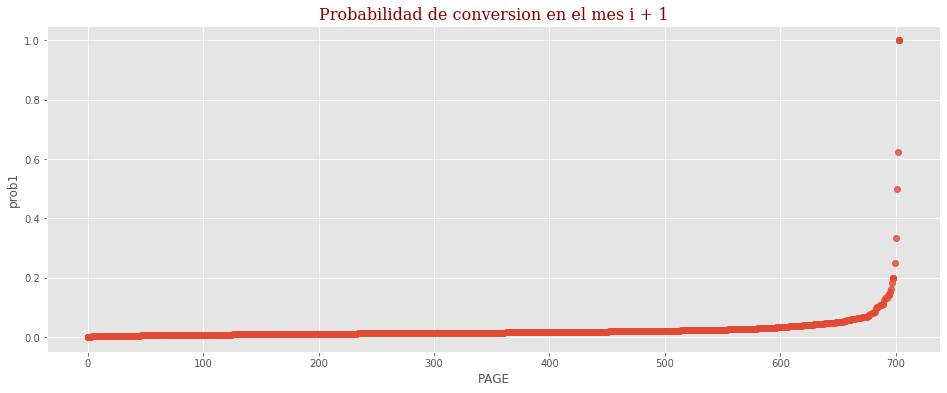

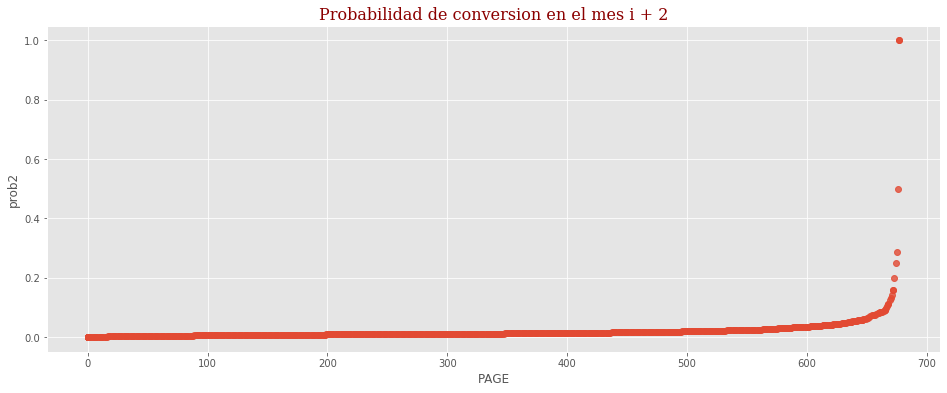

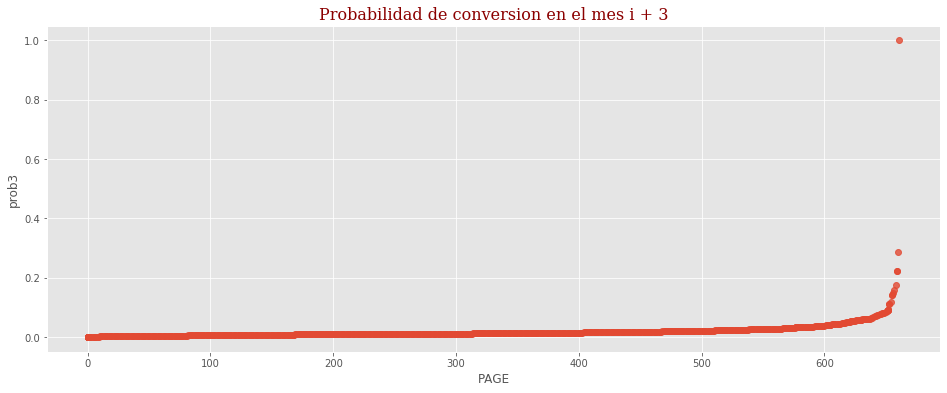

In [19]:
probs = probabilidades('PAGE', data, values=False)
# probs.sort_values(by='proportion', ascending=False)

probs.head()

probs.to_csv('page_probs.csv', sep=',', header=True)

In [20]:
page_group = pd.read_csv('./page_group.csv')
data = pd.merge(data, page_group, how='inner')
data.head()

FEC_EVENT  USER_ID  anio  mes  conversion+0  conversion+1  \
0 2018-03-30 07:35:48        0  2018    3           0.0           0.0   
1 2018-02-18 13:26:45        0  2018    2           0.0           0.0   
2 2018-03-04 18:04:12        0  2018    3           0.0           0.0   
3 2018-01-04 08:29:59        0  2018    1           0.0           0.0   
4 2018-01-04 08:52:16        0  2018    1           0.0           0.0   

   conversion+2  conversion+3 PAGE_descripcion  PAGE  diasemana  diames  hora  \
0           0.0           0.0    WEB : EMINENT     1          4      30     7   
1           0.0           0.0    WEB : EMINENT     1          6      18    13   
2           0.0           0.0    WEB : EMINENT     1          6       4    18   
3           0.0           0.0    WEB : EMINENT     1          3       4     8   
4           0.0           0.0    WEB : EMINENT     1          3       4     8   

    gm  
0  1.0  
1  1.0  
2  1.0  
3  1.0  
4  1.0

gm


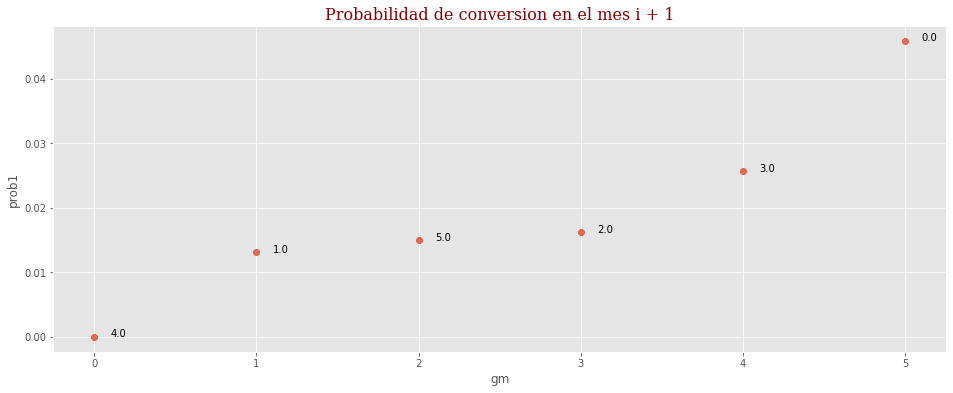

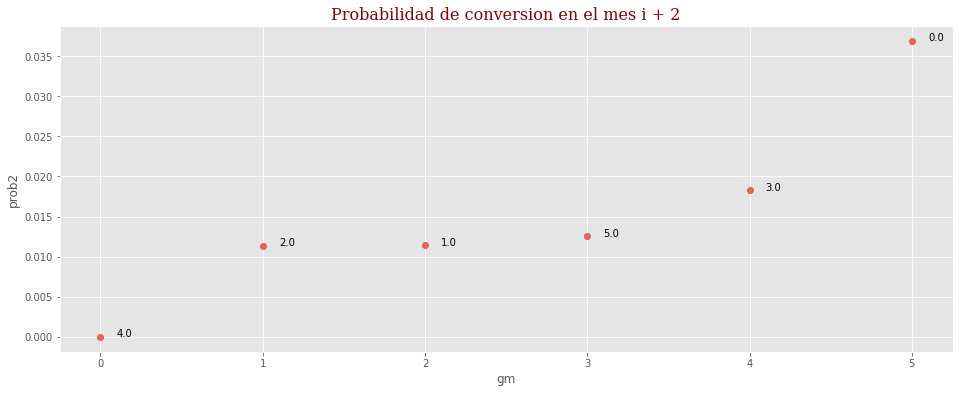

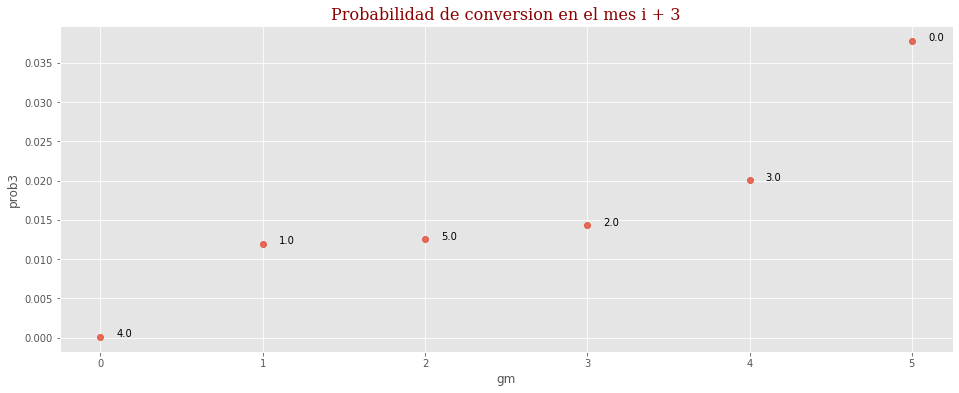

conversion+1  conversion+2  conversion+3  user_count      freq  \
gm                                                                    
0.0         204.0         164.0         168.0        1876      4440   
1.0      134711.0      117267.0      122400.0       11640  10239032   
2.0        2680.0        1875.0        2370.0        9604    165225   
3.0       44795.0       31860.0       35022.0       11618   1743965   
4.0           0.0           0.0           1.0        2509     10263   

     proportion     prob1  ord1     prob2  ord2     prob3  ord3  
gm                                                               
0.0    0.000248  0.045946   5.0  0.036937   5.0  0.037838   5.0  
1.0    0.570835  0.013157   1.0  0.011453   2.0  0.011954   1.0  
2.0    0.009211  0.016220   3.0  0.011348   1.0  0.014344   3.0  
3.0    0.097228  0.025686   4.0  0.018269   4.0  0.020082   4.0  
4.0    0.000572  0.000000   0.0  0.000000   0.0  0.000097   0.0

In [21]:
probs = probabilidades('gm', data)
# probs.sort_values(by='proportion', ascending=False)
probs.head()

In [22]:
probs['gp_prob'] = probs['prob1'] + probs['prob2'] + probs['prob3']
data = pd.merge(data, probs.reset_index()[['gm','gp_prob']], how='inner')
data.head()

FEC_EVENT  USER_ID  anio  mes  conversion+0  conversion+1  \
0 2018-03-30 07:35:48        0  2018    3           0.0           0.0   
1 2018-02-18 13:26:45        0  2018    2           0.0           0.0   
2 2018-03-04 18:04:12        0  2018    3           0.0           0.0   
3 2018-01-04 08:29:59        0  2018    1           0.0           0.0   
4 2018-01-04 08:52:16        0  2018    1           0.0           0.0   

   conversion+2  conversion+3 PAGE_descripcion  PAGE  diasemana  diames  hora  \
0           0.0           0.0    WEB : EMINENT     1          4      30     7   
1           0.0           0.0    WEB : EMINENT     1          6      18    13   
2           0.0           0.0    WEB : EMINENT     1          6       4    18   
3           0.0           0.0    WEB : EMINENT     1          3       4     8   
4           0.0           0.0    WEB : EMINENT     1          3       4     8   

    gm   gp_prob  
0  1.0  0.036564  
1  1.0  0.036564  
2  1.0  0.036564  
3  1.0  0.036564  
4  1.0  0.036564

### Dia

diames


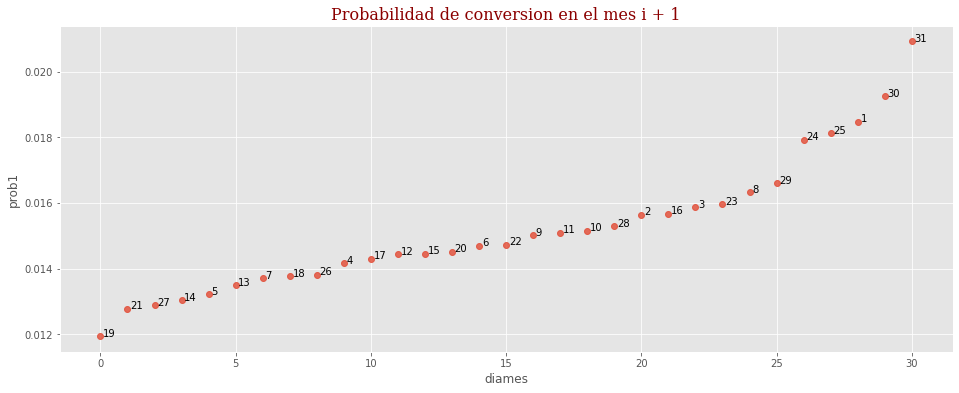

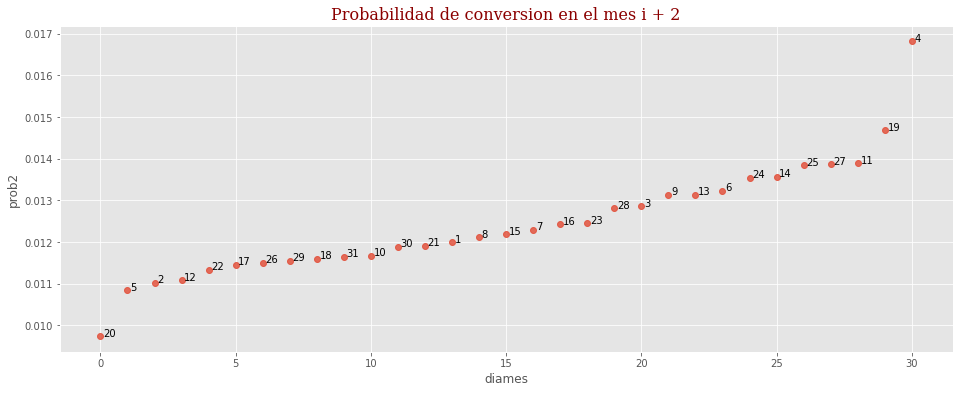

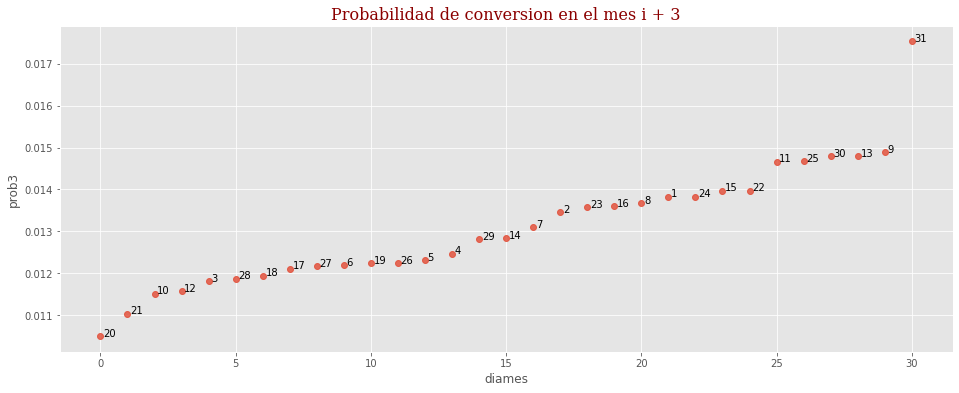

conversion+1  conversion+2  conversion+3  user_count     freq  \
diames                                                                  
1            11339.0        7363.0        8487.0        9891   613773   
2            10792.0        7607.0        9287.0       10056   689884   
3            12936.0       10484.0        9630.0       10324   815495   
4            11272.0       13392.0        9924.0       10376   796030   
5            13453.0       11040.0       12536.0       10709  1017940   

        proportion     prob1  ord1     prob2  ord2     prob3  ord3  
diames                                                              
1         0.034218  0.018474  28.0  0.011996  13.0  0.013828  21.0  
2         0.038462  0.015643  20.0  0.011026   2.0  0.013462  17.0  
3         0.045465  0.015863  22.0  0.012856  20.0  0.011809   4.0  
4         0.044379  0.014160   9.0  0.016823  30.0  0.012467  13.0  
5         0.056751  0.013216   4.0  0.010845   1.0  0.012315  12.0

In [23]:
probs = probabilidades('diames', data)
probs.head()

In [24]:
probs['dm_prob'] = probs['prob1'] + probs['prob2'] + probs['prob3']
data = pd.merge(data, probs.reset_index()[['diames','dm_prob']], how='inner')
data.head()

FEC_EVENT  USER_ID  anio  mes  conversion+0  conversion+1  \
0 2018-03-30 07:35:48        0  2018    3           0.0           0.0   
1 2018-01-30 11:24:48        0  2018    1           0.0           0.0   
2 2018-01-30 10:02:59        7  2018    1           0.0           0.0   
3 2018-01-30 10:17:30        7  2018    1           0.0           0.0   
4 2018-01-30 14:06:48       22  2018    1           0.0           0.0   

   conversion+2  conversion+3 PAGE_descripcion  PAGE  diasemana  diames  hora  \
0           0.0           0.0    WEB : EMINENT     1          4      30     7   
1           0.0           0.0    WEB : EMINENT     1          1      30    11   
2           0.0           0.0    WEB : EMINENT     1          1      30    10   
3           0.0           0.0    WEB : EMINENT     1          1      30    10   
4           0.0           0.0    WEB : EMINENT     1          1      30    14   

    gm   gp_prob   dm_prob  
0  1.0  0.036564  0.045931  
1  1.0  0.036564  0.045931  
2  1.0  0.036564  0.045931  
3  1.0  0.036564  0.045931  
4  1.0  0.036564  0.045931

diasemana


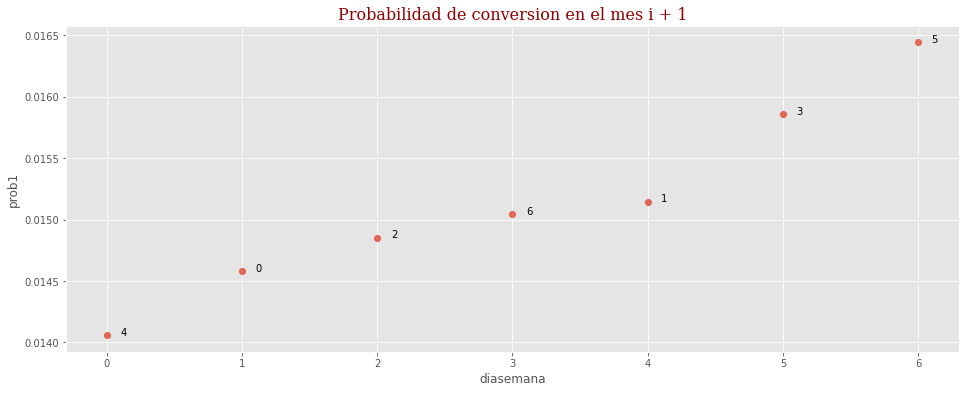

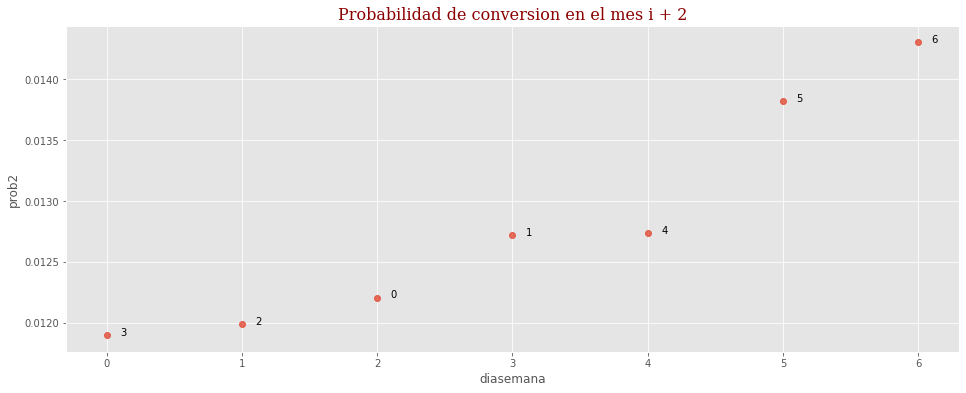

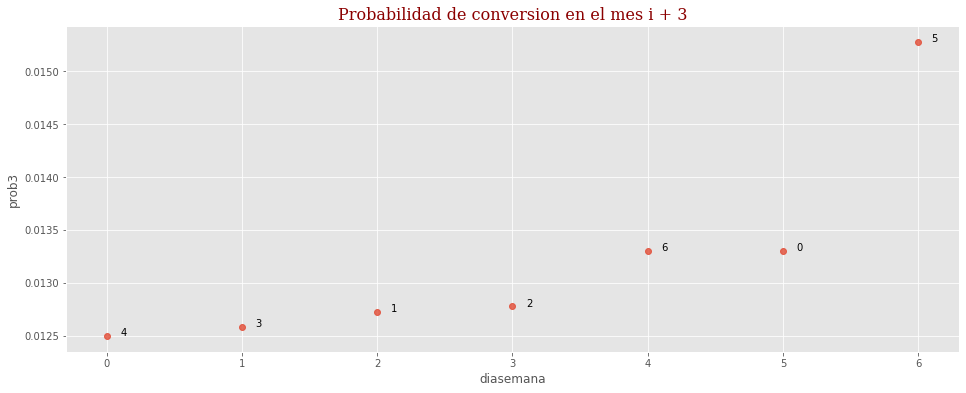

conversion+1  conversion+2  conversion+3  user_count     freq  \
diasemana                                                                  
0               51842.0       43399.0       47303.0       11424  3556010   
1               47727.0       40080.0       40104.0       11380  3151448   
2               49781.0       40172.0       42824.0       11432  3351480   
3               51662.0       38758.0       40989.0       11432  3257922   
4               40464.0       36655.0       35973.0       11374  2877953   

           proportion     prob1  ord1     prob2  ord2     prob3  ord3  
diasemana                                                              
0            0.198251  0.014579   1.0  0.012204   2.0  0.013302   5.0  
1            0.175696  0.015144   4.0  0.012718   3.0  0.012726   2.0  
2            0.186848  0.014853   2.0  0.011986   1.0  0.012778   3.0  
3            0.181632  0.015857   5.0  0.011897   0.0  0.012581   1.0  
4            0.160448  0.014060   0.0  0.012736   4.0  0.012500   0.0

In [25]:
probs = probabilidades('diasemana', data)
probs.head()

In [26]:
probs['ds_prob'] = probs['prob1'] + probs['prob2'] + probs['prob3']
data = pd.merge(data, probs.reset_index()[['diasemana','ds_prob']], how='inner')
data.head()

FEC_EVENT  USER_ID  anio  mes  conversion+0  conversion+1  \
0 2018-03-30 07:35:48        0  2018    3           0.0           0.0   
1 2018-03-30 23:25:47       24  2018    3           0.0           0.0   
2 2018-03-30 07:24:25       24  2018    3           0.0           0.0   
3 2018-03-30 07:25:13       24  2018    3           0.0           0.0   
4 2018-03-30 18:31:48      129  2018    3           0.0           0.0   

   conversion+2  conversion+3 PAGE_descripcion  PAGE  diasemana  diames  hora  \
0           0.0           0.0    WEB : EMINENT     1          4      30     7   
1           0.0           0.0    WEB : EMINENT     1          4      30    23   
2           0.0           0.0    WEB : EMINENT     1          4      30     7   
3           0.0           0.0    WEB : EMINENT     1          4      30     7   
4           0.0           0.0    WEB : EMINENT     1          4      30    18   

    gm   gp_prob   dm_prob   ds_prob  
0  1.0  0.036564  0.045931  0.039296  
1  1.0  0.036564  0.045931  0.039296  
2  1.0  0.036564  0.045931  0.039296  
3  1.0  0.036564  0.045931  0.039296  
4  1.0  0.036564  0.045931  0.039296

hora


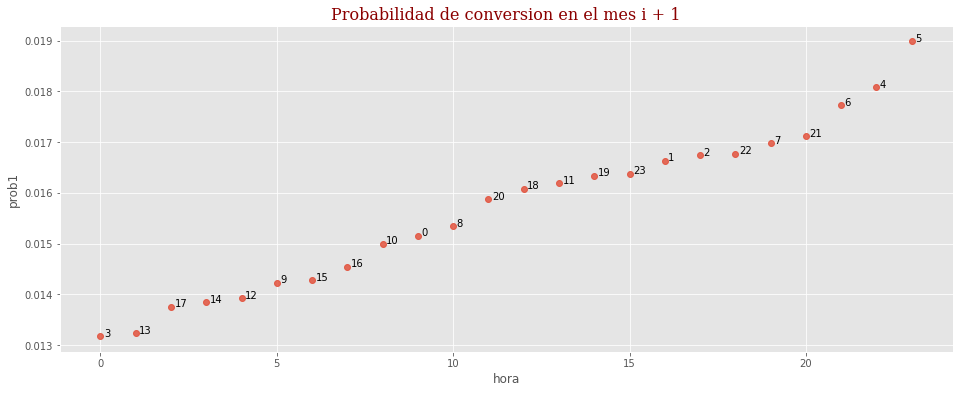

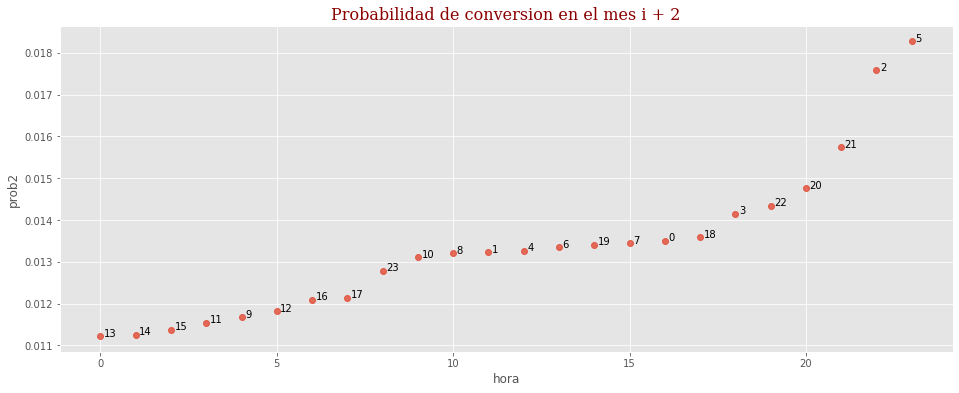

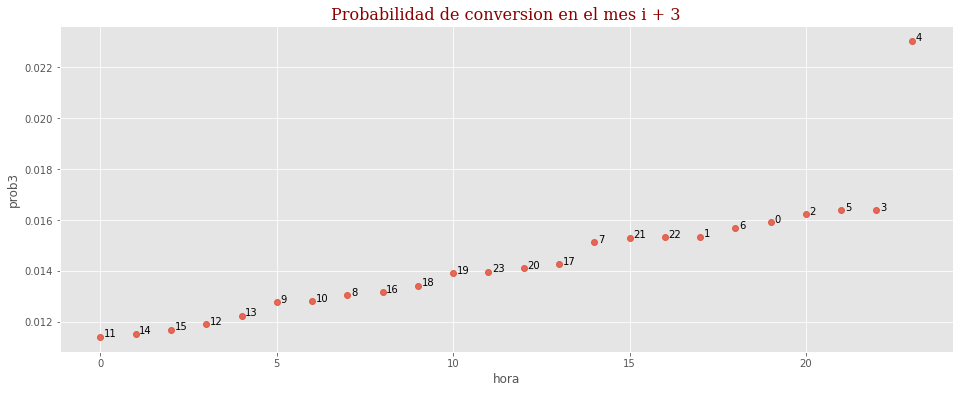

conversion+1  conversion+2  conversion+3  user_count    freq  \
hora                                                                 
0           3236.0        2883.0        3396.0        5974  213492   
1           1714.0        1363.0        1581.0        3885  103024   
2            950.0         997.0         920.0        2509   56725   
3            624.0         670.0         776.0        1848   47351   
4            915.0         671.0        1166.0        1690   50597   

      proportion     prob1  ord1     prob2  ord2     prob3  ord3  
hora                                                              
0       0.011902  0.015157   9.0  0.013504  16.0  0.015907  19.0  
1       0.005744  0.016637  16.0  0.013230  11.0  0.015346  17.0  
2       0.003162  0.016747  17.0  0.017576  22.0  0.016219  20.0  
3       0.002640  0.013178   0.0  0.014150  18.0  0.016388  22.0  
4       0.002821  0.018084  22.0  0.013262  12.0  0.023045  23.0

In [27]:
probs = probabilidades('hora', data)
probs.head()

In [28]:
probs['h_prob'] = probs['prob1'] + probs['prob2'] + probs['prob3']
data = pd.merge(data, probs.reset_index()[['hora','h_prob']], how='inner')
data.head()

FEC_EVENT  USER_ID  anio  mes  conversion+0  conversion+1  \
0 2018-03-30 07:35:48        0  2018    3           0.0           0.0   
1 2018-03-30 07:24:25       24  2018    3           0.0           0.0   
2 2018-03-30 07:25:13       24  2018    3           0.0           0.0   
3 2018-03-30 07:15:38     6571  2018    3           0.0           0.0   
4 2018-11-30 07:47:46      341  2018   11           0.0           0.0   

   conversion+2  conversion+3 PAGE_descripcion  PAGE  diasemana  diames  hora  \
0           0.0           0.0    WEB : EMINENT     1          4      30     7   
1           0.0           0.0    WEB : EMINENT     1          4      30     7   
2           0.0           0.0    WEB : EMINENT     1          4      30     7   
3           0.0           0.0    WEB : EMINENT     1          4      30     7   
4           0.0           0.0    WEB : EMINENT     1          4      30     7   

    gm   gp_prob   dm_prob   ds_prob    h_prob  
0  1.0  0.036564  0.045931  0.039296  0.045553  
1  1.0  0.036564  0.045931  0.039296  0.045553  
2  1.0  0.036564  0.045931  0.039296  0.045553  
3  1.0  0.036564  0.045931  0.039296  0.045553  
4  1.0  0.036564  0.045931  0.039296  0.045553

### Sesiones por usuario

In [30]:
# Definimos un límite de tiempo entre eventos (Cuánto tiempo pasa hasta que expira la sesión?)
T = timedelta(seconds=30*60)

# data = data.loc[:,['USER_ID', 'FEC_EVENT', 'anio', 'mes']]
# Ordenamos el dataset por usuario y fecha de evento
data = data.sort_values(by=['USER_ID','FEC_EVENT'])

# Agregamos una columna con la fecha de evento anterior
data['last_date'] = data.groupby(['USER_ID'])['FEC_EVENT'].shift()

# Crear flag de nueva sesión cada vez que hay un nuevo ingreso
data['new_session'] = (((data['FEC_EVENT']
                            - data['last_date'])>=T) | (data['last_date'].isnull())).astype(int)
data['inc'] = data.groupby('USER_ID')['new_session'].cumsum()

# Creamos el id de sesión
data['session_id'] = data['USER_ID'].astype(str) + '_' + data['inc'].astype(str)
data = data.drop('inc', axis=1)

# print(data.head())

                   FEC_EVENT  USER_ID  anio  mes  conversion+0  conversion+1  \
15574578 2018-01-01 09:56:47        0  2018    1           0.0           0.0   
15574579 2018-01-01 09:57:19        0  2018    1           0.0           0.0   
15574542 2018-01-01 09:57:48        0  2018    1           0.0           0.0   
15579509 2018-01-01 09:57:48        0  2018    1           0.0           0.0   
15579872 2018-01-01 09:57:49        0  2018    1           0.0           0.0   

          conversion+2  conversion+3  \
15574578           0.0           0.0   
15574579           0.0           0.0   
15574542           0.0           0.0   
15579509           0.0           0.0   
15579872           0.0           0.0   

                                           PAGE_descripcion  PAGE  ...  \
15574578                                HB : MASIVO : LOGIN    14  ...   
15574579                                HB : MASIVO : LOGIN    14  ...   
15574542  HB : EMINENT : CONSULTAS : RESUMEN DE PRODUCTO

# Agrupar por id de usuario, año y mes para el dataset final

Para cada usuario, año y mes, tengo la cantidad de sesiones, si convirtió o no en ese mes, y la fecha del último evento

In [50]:
grouped_data = data.groupby(['USER_ID','anio','mes']
                            , as_index=False).agg({'PAGE':'count', 'conversion+0':'sum'
                                                   , 'FEC_EVENT':'max', 'gp_prob':'mean'
                                                   ,'dm_prob':'mean','ds_prob':'mean'
                                                   ,'h_prob':'mean', 'new_session':'sum'})

grouped_data['conversion+0'] = np.where(grouped_data['conversion+0']> 0, 1, 0)

grouped_data = grouped_data.rename(columns = {'PAGE':'paginas_visitadas', 'conversion+0':'conversiones_previas'
                                              ,'FEC_EVENT':'ultimo_evento','gp_prob':'page_group','dm_prob':'diames'
                                              ,'ds_prob':'diasemana', 'h_prob':'hora'
                                              ,'new_session':'cantidad_sesiones'})
# Agregamos el tiempo desde la última transacción
grouped_data['tiempo_ultimo_evento'] = ((dt.datetime.now() - grouped_data['ultimo_evento'])).astype('timedelta64[s]')

grouped_data.shape

(104255, 12)

In [51]:
grouped_data.head()

USER_ID  anio  mes  paginas_visitadas  conversiones_previas  \
0        0  2018    1                710                     0   
1        0  2018    2                375                     0   
2        0  2018    3                756                     0   
3        0  2018    4                497                     0   
4        0  2018    5                496                     0   

        ultimo_evento  page_group    diames  diasemana      hora  \
0 2018-01-31 12:16:28    0.045478  0.042184   0.040192  0.040449   
1 2018-02-28 21:38:43    0.045314  0.039823   0.040293  0.041754   
2 2018-03-31 20:08:59    0.043872  0.040972   0.040376  0.040694   
3 2018-04-30 08:29:50    0.044660  0.040243   0.040716  0.040218   
4 2018-05-31 13:58:21    0.044371  0.041287   0.040377  0.040260   

   cantidad_sesiones  tiempo_ultimo_evento  
0                 53            48562409.0  
1                 30            46109474.0  
2                 48            43436458.0  
3                 36            40886407.0  
4                 32            38188296.0

In [53]:
grouped_data.to_csv('observaciones_Vero.csv',sep=',',header=True)

In [16]:
sessions = data.groupby(['session_id', 'USER_ID']).agg({'FEC_EVENT':['min','max','count'], 'conversion':'sum'})
sessions.columns = sessions.columns.droplevel()
# sessions.columns = ['event count','min timestamp','max timestamp','unique skus']
# sessions.columns = sessions.columns.astype('object')
sessions = sessions.reset_index()
print(sessions['session_id'].nunique())
sessions.loc[sessions['sum'] > 0].head()

1863834


session_id  USER_ID                 min                 max  count   sum
2667  10016_100    10016 2018-05-02 12:49:44 2018-05-02 12:49:59      3   3.0
2668  10016_101    10016 2018-05-02 14:19:34 2018-05-02 14:23:13     14  14.0
2669  10016_102    10016 2018-05-03 09:40:35 2018-05-03 10:43:25     44  44.0
2670  10016_103    10016 2018-05-04 07:39:09 2018-05-04 07:45:24      5   5.0
2671  10016_104    10016 2018-05-04 10:13:55 2018-05-04 10:19:18      4   4.0

Con qué PAGE inician las sesiones??

In [15]:
data.loc[data['new_session']==1,['USER_ID', 'FEC_EVENT', 'PAGE_descripcion']]['PAGE_descripcion'].value_counts()

/LOGIN                                                   786139
WEB : PERSONAS                                           429831
WEB : EMINENT                                            140243
/ERROR/SESIONEXPIRADA                                    118415
PRODUCTOSYSERVICIOS : NUEVO ONLINE BANKING GALICIA        60500
HB : MASIVO : LOGIN                                       57658
PRODUCTOSYSERVICIOS : ONLINEBANKING                       54745
WEB : EMPRESAS                                            41847
HB : MASIVO : CONSULTAS : RESUMEN DE PRODUCTOS : HOME     36063
/INICIO                                                   34280
WEB : NEGOCIOSYPYMES                                      19663
HB : EMINENT : CONSULTAS : RESUMEN DE PRODUCTOS : HOM     10610
HB : EMINENT : LOGIN                                       8058
PRODUCTOSYSERVICIOS : COTIZADOR                            5559
/ERROR/ERROROUT                                            3867
WEB : RURAL                             

In [17]:
# data.loc[data['conversion']==0]
print(data.shape)
print(pageviews.shape)

(17996751, 9)
(17936934, 10)


### Análisis de conversiones
Analizamos si las conversiones en el último trimestre del 2018 dependen de la actividad en meses anteriores

In [18]:
hist = data.loc[data['mes'] < 10,]
hist = hist.rename(columns = {'conversion':'prev_conversions'})

# Convirtieron en el último cuarto?
labels = data.loc[data['mes'] >= 10,]
labels = labels.groupby('USER_ID', as_index=False).agg({'conversion':'sum'})
labels['conversion'] = np.where(labels['conversion']> 0, 1, 0)

hist = pd.merge(hist, labels, how='left')
hist = hist.set_index('USER_ID', drop=True)
hist = hist.rename(columns = {'conversion':'label'})
hist.head()

FEC_EVENT  anio  mes  prev_conversions  \
USER_ID                                                    
0       2018-01-01 09:56:47  2018    1               0.0   
0       2018-01-01 09:57:19  2018    1               0.0   
0       2018-01-01 09:57:48  2018    1               0.0   
0       2018-01-01 09:57:48  2018    1               0.0   
0       2018-01-01 09:57:49  2018    1               0.0   

                                          PAGE_descripcion  \
USER_ID                                                      
0                                      HB : MASIVO : LOGIN   
0                                      HB : MASIVO : LOGIN   
0        HB : EMINENT : CONSULTAS : RESUMEN DE PRODUCTO...   
0        HB : EMINENT : CONSULTAS : ERRORES : INFORMACI...   
0        HB : EMINENT : CONSULTAS : ERRORES : INFORMACI...   

                  last_date  new_session session_id  label  
USER_ID                                                     
0                       NaT            1        0_1    0.0  
0       2018-01-01 09:56:47            0        0_1    0.0  
0       2018-01-01 09:57:19            0        0_1    0.0  
0       2018-01-01 09:57:48            0        0_1    0.0  
0       2018-01-01 09:57:48            0        0_1    0.0

#### Páginas más visitadas por quienes convirtieron

In [42]:
hist.loc[hist['label']==1,['USER_ID', 'FEC_EVENT', 'PAGE_descripcion']]['PAGE_descripcion'].value_counts()

/LOGIN                                                   1998159
/INICIO                                                  1887400
WEB : PERSONAS                                            525701
/PAGOS/INICIO                                             465912
/TARJETAS/INICIO                                          448812
/ERROR/SESIONEXPIRADA                                     443534
HB : MASIVO : CONSULTAS : RESUMEN DE PRODUCTOS : HOME     366334
/CUENTAS/MIS-CUENTAS                                      352155
/CUENTAS/INICIO                                           335351
HB : EMINENT : CONSULTAS : RESUMEN DE PRODUCTOS : HOM     306264
/TRANSFERENCIAS/INICIO                                    291298
/TARJETAS/CONSUMOS/0                                      271765
/INVERSIONES/INICIO                                       266024
HB : MASIVO : LOGIN                                       249837
WEB : EMINENT                                             177941
/TARJETAS/RESUMEN/0      

In [51]:
# page.loc[page['PAGE_descripcion'].astype(str).str.contains('QUIERO'),:]
hist.loc[hist['PAGE_descripcion'].astype(str).str.contains('EMINENT'),('label')].value_counts()

0.0    813001
1.0     24589
Name: label, dtype: int64

In [52]:
hist['prestamo'] = np.where(hist['PAGE_descripcion'].astype(str).str.contains('PRESTAMO'), 1, 0)
hist['transferencia'] = np.where(hist['PAGE_descripcion'].astype(str).str.contains('TRANSFERENCIA'), 1, 0)
hist['inversiones'] = np.where(hist['PAGE_descripcion'].astype(str).str.contains('INVERSIONES'), 1, 0)
hist['solicitud'] = np.where(hist['PAGE_descripcion'].astype(str).str.contains('SOLICITAR'), 1, 0)
hist['quiero'] = np.where(hist['PAGE_descripcion'].astype(str).str.contains('QUIERO'), 1, 0)
hist['pagos'] = np.where(hist['PAGE_descripcion'].astype(str).str.contains('PAGOS'), 1, 0)
hist['eminent'] = np.where(hist['PAGE_descripcion'].astype(str).str.contains('EMINENT'), 1, 0)
hist.head()

FEC_EVENT  anio  mes  prev_conversions  \
USER_ID                                                    
0       2018-01-01 09:56:47  2018    1               0.0   
0       2018-01-01 09:57:19  2018    1               0.0   
0       2018-01-01 09:57:48  2018    1               0.0   
0       2018-01-01 09:57:48  2018    1               0.0   
0       2018-01-01 09:57:49  2018    1               0.0   

                                          PAGE_descripcion  \
USER_ID                                                      
0                                      HB : MASIVO : LOGIN   
0                                      HB : MASIVO : LOGIN   
0        HB : EMINENT : CONSULTAS : RESUMEN DE PRODUCTO...   
0        HB : EMINENT : CONSULTAS : ERRORES : INFORMACI...   
0        HB : EMINENT : CONSULTAS : ERRORES : INFORMACI...   

                  last_date  new_session session_id  label  prestamo  \
USER_ID                                                                
0                       NaT            1        0_1    0.0         0   
0       2018-01-01 09:56:47            0        0_1    0.0         0   
0       2018-01-01 09:57:19            0        0_1    0.0         0   
0       2018-01-01 09:57:48            0        0_1    0.0         0   
0       2018-01-01 09:57:48            0        0_1    0.0         0   

         transferencia  inversiones  solicitud  quiero  pagos  eminent  
USER_ID                                                                 
0                    0            0          0       0      0        0  
0                    0            0          0       0      0        0  
0                    0            0          0       0      0        1  
0                    0            0          0       0      0        1  
0                    0            0          0       0      0        1

In [21]:
hist['solicitud'].sum()

188978

### Agrupo por user_id, mes, año

In [53]:
grouped_data = hist.groupby(['USER_ID','anio','mes'], as_index=False).agg({'new_session':'count', 'label':'sum'
                                                                           , 'prestamo':'sum', 'transferencia':'sum'
                                                                           , 'inversiones':'sum', 'solicitud':'sum'
                                                                           , 'quiero':'sum', 'pagos':'sum'
                                                                           , 'eminent':'sum'})
grouped_data['label'] = np.where(grouped_data['label']> 0, 1, 0)

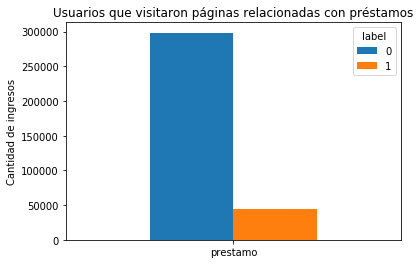

In [24]:
# Visitaron páginas de préstamos quienes convirtieron?
plotdata = grouped_data.loc[:,('label','prestamo')].groupby('label').sum()
plotdata.T.plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Usuarios que visitaron páginas relacionadas con préstamos')
plt.show()

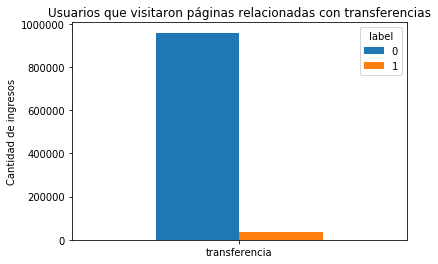

In [25]:
# Visitaron páginas de transferencias quienes convirtieron?
plotdata = grouped_data.loc[:,('label','transferencia')].groupby('label').sum()
plotdata.T.plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Usuarios que visitaron páginas relacionadas con transferencias')
plt.show()

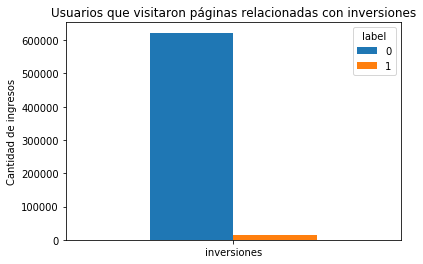

In [26]:
# Visitaron páginas de inversiones quienes convirtieron?
plotdata = grouped_data.loc[:,('label','inversiones')].groupby('label').sum()
plotdata.T.plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Usuarios que visitaron páginas relacionadas con inversiones')
plt.show()

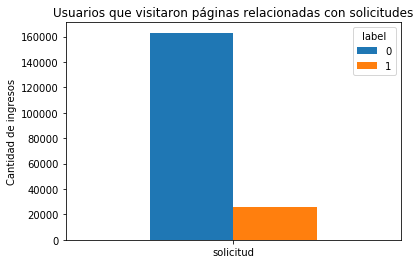

In [27]:
# Visitaron páginas de solicitudes quienes convirtieron?
plotdata = grouped_data.loc[:,('label','solicitud')].groupby('label').sum()
plotdata.T.plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Usuarios que visitaron páginas relacionadas con solicitudes')
plt.show()

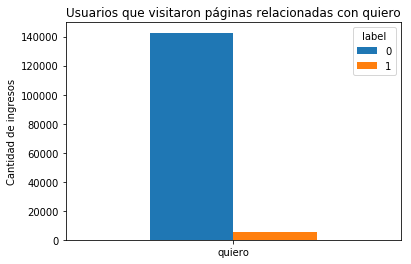

In [47]:
# Visitaron páginas de quiero quienes convirtieron?
plotdata = grouped_data.loc[:,('label','quiero')].groupby('label').sum()
plotdata.T.plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Usuarios que visitaron páginas relacionadas con quiero')
plt.show()

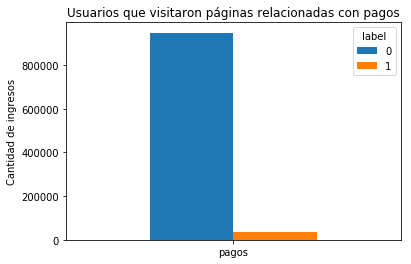

In [50]:
# Visitaron páginas de pagos quienes convirtieron?
plotdata = grouped_data.loc[:,('label','pagos')].groupby('label').sum()
plotdata.T.plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Usuarios que visitaron páginas relacionadas con pagos')
plt.show()

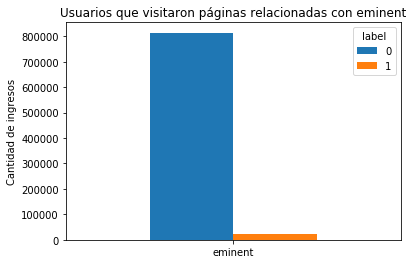

In [54]:
# Visitaron páginas de eminent quienes convirtieron?
plotdata = grouped_data.loc[:,('label','eminent')].groupby('label').sum()
plotdata.T.plot.bar(rot=0)
plt.xlabel('')
plt.ylabel('Cantidad de ingresos')
plt.title('Usuarios que visitaron páginas relacionadas con eminent')
plt.show()